## Goal: Compute length distributions of transcripts annotated in GENCODE

Probably have to split by gene biotypes

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import upsetplot
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = pr.read_gtf(proc_cfg(config['ref']['gtf'], od)).df

In [4]:
df.gene_type.unique()

array(['lncRNA', 'protein_coding', 'misc_RNA', 'snRNA', 'rRNA',
       'pseudogene', 'processed_pseudogene',
       'transcribed_unprocessed_pseudogene', 'miRNA',
       'transcribed_processed_pseudogene', 'unprocessed_pseudogene',
       'TEC', 'scaRNA', 'snoRNA', 'transcribed_unitary_pseudogene',
       'unitary_pseudogene', 'rRNA_pseudogene', 'IG_V_pseudogene',
       'scRNA', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene', 'sRNA', 'ribozyme',
       'vault_RNA', 'translated_processed_pseudogene', 'TR_V_pseudogene',
       'TR_V_gene', 'TR_D_gene', 'TR_J_gene', 'TR_C_gene',
       'IG_C_pseudogene', 'TR_J_pseudogene', 'IG_J_pseudogene',
       'IG_D_gene', 'IG_pseudogene', 'artifact', 'Mt_tRNA', 'Mt_rRNA'],
      dtype=object)

In [5]:
df = df.loc[df.Feature == 'exon']

In [7]:
# get length of each transcript
df = df[['Start', 'End', 'transcript_id', 'gene_type']]
df['exon_len'] = df.End-df.Start
df.drop(['Start', 'End'], axis=1)
df = df.groupby(['transcript_id', 'gene_type']).sum().reset_index()

In [8]:
df.columns

Index(['transcript_id', 'gene_type', 'Start', 'End', 'exon_len'], dtype='object')

In [9]:
df.head()

,transcript_id,gene_type,Start,End,exon_len
0,ENST00000000233.10,protein_coding,765539215,765540247,1032
1,ENST00000000412.8,protein_coding,62611111,62613561,2450
2,ENST00000000442.11,protein_coding,450186324,450188598,2274
3,ENST00000001008.6,protein_coding,27992170,27995885,3715
4,ENST00000001146.7,protein_coding,432823780,432828336,4556


In [18]:
temp = df.loc[df.gene_type.isin(['protein_coding', 'lncRNA'])]

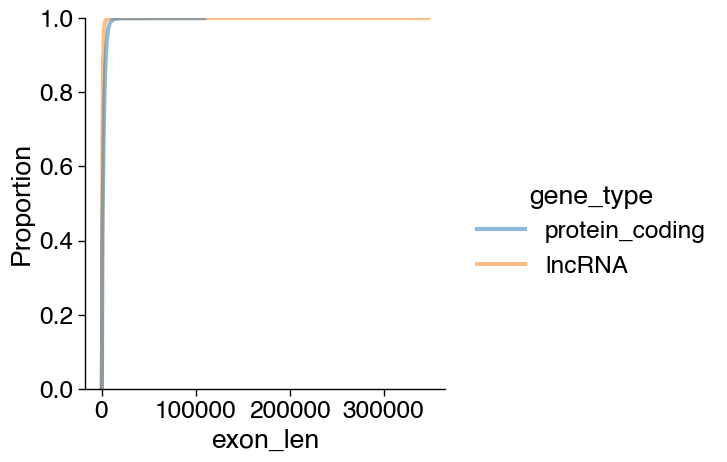

In [20]:
# biotype
init_plot_settings()
ax = sns.displot(temp,
                 x='exon_len', kind='ecdf',
                 hue='gene_type',
                 linewidth=3, alpha=0.5)

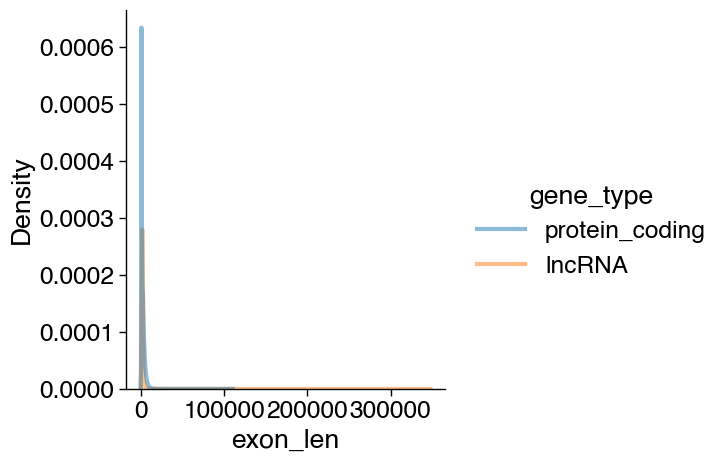

In [13]:
# biotype
init_plot_settings()
ax = sns.displot(temp,
                 x='exon_len', kind='kde',
                 hue='gene_type',
                 linewidth=3, common_norm=False, alpha=0.5)

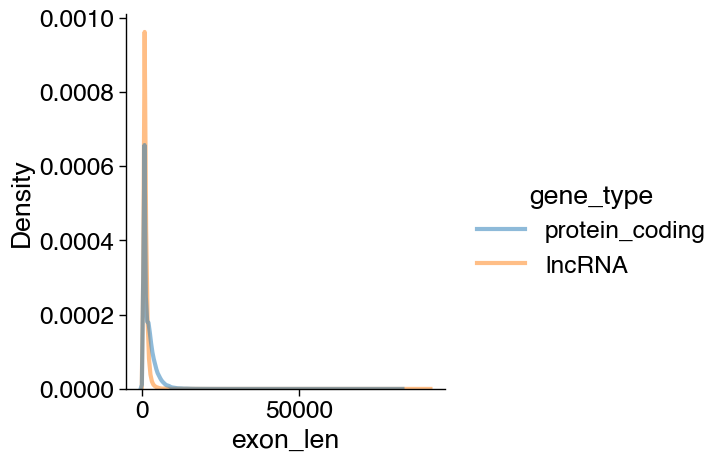

In [16]:
# biotype
init_plot_settings()
temp = temp.loc[temp.exon_len<1e5]
ax = sns.displot(temp,
                 x='exon_len', kind='kde',
                 hue='gene_type',
                 linewidth=3, common_norm=False, alpha=0.5)

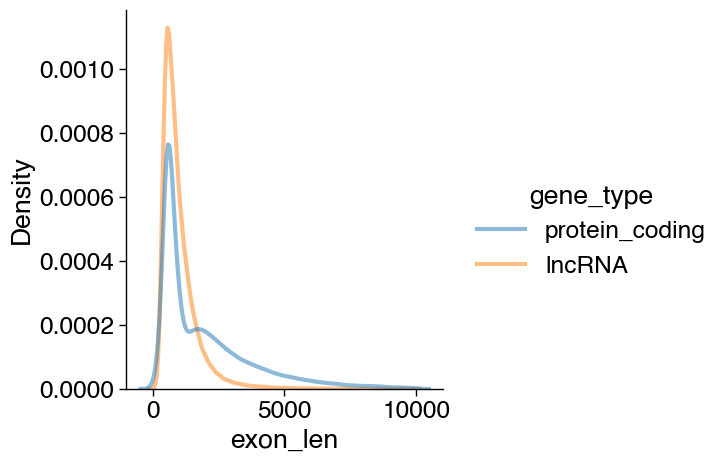

In [17]:
# biotype
init_plot_settings()
temp = temp.loc[temp.exon_len<1e4]
ax = sns.displot(temp,
                 x='exon_len', kind='kde',
                 hue='gene_type',
                 linewidth=3, common_norm=False, alpha=0.5)

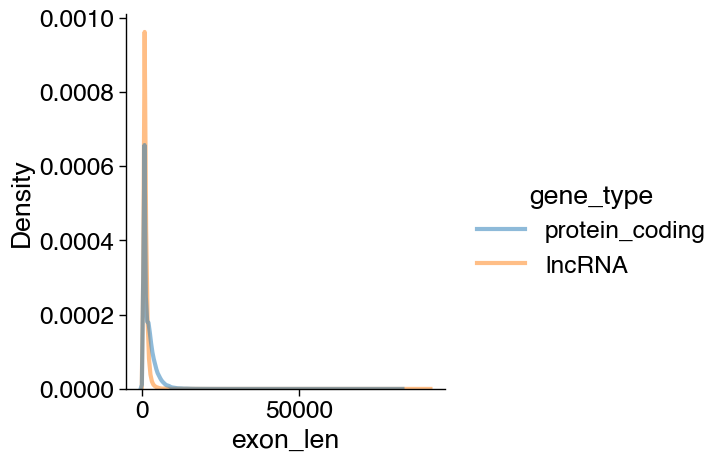

In [21]:
# biotype
init_plot_settings()
temp = temp.loc[temp.exon_len<1e5]
ax = sns.displot(temp,
                 x='exon_len', kind='kde',
                 hue='gene_type',
                 linewidth=3, common_norm=False, alpha=0.5)

In [25]:
## What % are shorter than 4kb?
df['n_t_total'] = df.groupby('gene_type').transcript_id.transform('nunique')
df['less_4k'] = df.exon_len<=4e3
df['n_less_4k'] = df.groupby(['gene_type', 'less_4k']).transcript_id.transform('nunique')
df.head()

,transcript_id,gene_type,Start,End,exon_len,n_t_total,less_4k,n_less_4k
0,ENST00000000233.10,protein_coding,765539215,765540247,1032,171867,True,148334
1,ENST00000000412.8,protein_coding,62611111,62613561,2450,171867,True,148334
2,ENST00000000442.11,protein_coding,450186324,450188598,2274,171867,True,148334
3,ENST00000001008.6,protein_coding,27992170,27995885,3715,171867,True,148334
4,ENST00000001146.7,protein_coding,432823780,432828336,4556,171867,False,23533


In [29]:
temp = df.loc[df.less_4k==False]
temp = temp[['gene_type', 'n_t_total', 'n_less_4k']].drop_duplicates()
temp.head()

,gene_type,n_t_total,n_less_4k
4,protein_coding,171867,23533
1735,lncRNA,192292,1794
5719,transcribed_unprocessed_pseudogene,1602,44
21101,transcribed_unitary_pseudogene,183,9
25767,processed_pseudogene,9491,12


In [30]:
temp['perc'] = (temp['n_less_4k']/temp['n_t_total'])*100

In [31]:
temp

,gene_type,n_t_total,n_less_4k,perc
4,protein_coding,171867,23533,13.692565
1735,lncRNA,192292,1794,0.932956
5719,transcribed_unprocessed_pseudogene,1602,44,2.746567
21101,transcribed_unitary_pseudogene,183,9,4.918033
25767,processed_pseudogene,9491,12,0.126436
33869,transcribed_processed_pseudogene,1161,4,0.344531
43666,unprocessed_pseudogene,1957,5,0.255493
180925,artifact,19,1,5.263158
185843,TEC,1040,47,4.519231
